In this notebook, we apply persistent homology with pixel intensity filtration to the 2D segmentation of cells.
The image data analyzed in this notebook was retrieved from
https://github.com/BiAPoL/HIP_Introduction_to_Napari_and_image_processing_with_Python_2022/tree/main/data

In [1]:
import cv2
import homcloud.interface as hc
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
image = cv2.imreadmulti("membrane.tif", flags =cv2.IMREAD_UNCHANGED)
imageSlices=image[1]

In [3]:
pict=imageSlices[30]

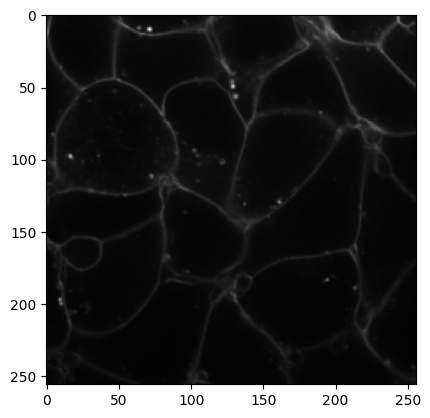

In [4]:
plt.imshow(pict,cmap='gray')
plt.show()

In [5]:
%%time
hc.BitmapPHTrees.for_bitmap_levelset(pict, "sublevel", save_to="grayscale-tree.pdgm")
phtrees = hc.PDList("grayscale-tree.pdgm").bitmap_phtrees(0)

CPU times: total: 625 ms
Wall time: 1.33 s


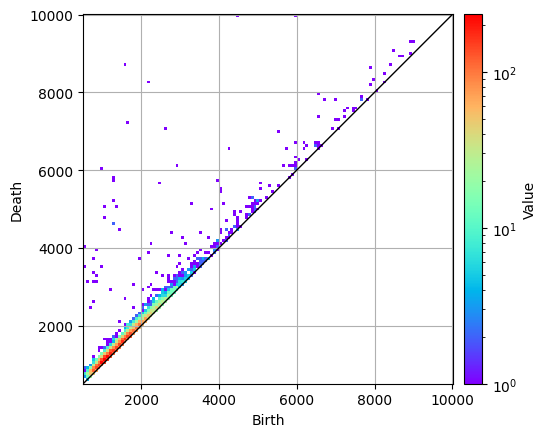

In [6]:
pdlist_with_tree = hc.PDList("grayscale-tree.pdgm")
pd0=pdlist_with_tree[0]
pd0.histogram().plot(colorbar={"type": "log"})

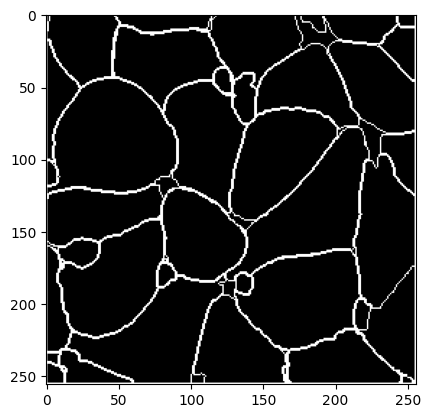

CPU times: total: 250 ms
Wall time: 538 ms


In [7]:
%%time
lifethres=1000#####Threshold value for the persistence
volumethres=50#####Threshold value for the volume size to be detected
nodes = [node for node in phtrees.nodes if node.lifetime() > lifethres and node.death_time() != np.inf and len(node.volume())>volumethres]
lifetimes=[nodes[i].death_time()-nodes[i].birth_time() for i in range (0,len(nodes))]
sorted_ascending=np.argsort(np.array(lifetimes))
non_overlapping_segmentation=[[] for i in range (0,len(nodes))]
h,w=pict.shape
segmentedpixels=np.zeros((h,w))
enhanced_contours=[]
for i in range (0,len(nodes)):
    detected_mask=np.zeros((h,w))
    mask_spots=tuple(np.transpose(np.array(nodes[sorted_ascending[i]].volume())).tolist())
    detected_mask[mask_spots]=255
    kernel=np.array([[1,1,1],[1,1,1],[1,1,1]])
    dilated_mask=cv2.dilate(detected_mask,kernel=kernel,iterations=2)
    non_overlapping_mask=copy.deepcopy(dilated_mask)
    non_overlapping_mask[np.where(segmentedpixels)]=0
    segmentedpixels[np.where(non_overlapping_mask)]=255
    non_overlapping_mask=non_overlapping_mask.astype('uint8')
    contours, hierarchy = cv2.findContours(non_overlapping_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for u in range (0,len(contours)):
        enhanced_contours.extend([contours[u][t][0].tolist() for t in range (0,len(contours[u]))])
slice_contour_img=np.zeros((h,w))
contour_spots=(np.transpose(np.array(enhanced_contours)).tolist()[1],np.transpose(np.array(enhanced_contours)).tolist()[0])
slice_contour_img[contour_spots]=255
#####draw white lines if necessary (for the detection of connected components in the next step)
slice_contour_img[0,:]=255
slice_contour_img[:,0]=255
slice_contour_img[h-1,:]=255
slice_contour_img[:,w-1]=255
#####
slice_contour_img=slice_contour_img.astype('uint8')
plt.imshow(slice_contour_img, cmap='gray')
plt.show()

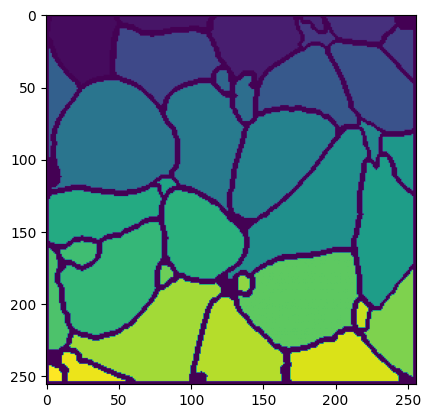

In [8]:
large_area_threshold=10000
small_area_threshold=50
X=copy.deepcopy(slice_contour_img)
X=cv2.dilate(X,kernel=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype='uint8'),iterations=1)<150#####increase the thickness of the contours if needed
n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(X.astype('uint8'), connectivity=4)
Y=np.zeros((h,w))
large_areas_omitted=np.where(stats[:,4]<large_area_threshold)[0]#####Omitting too large structures (e.g. background component)
small_areas_omitted=np.where(stats[:,4]>small_area_threshold)[0]#####Omitting too small structures
Remaining_areas=np.intersect1d(large_areas_omitted,small_areas_omitted)
for l in range (0,len(Remaining_areas)):
    Y[np.where(labels==Remaining_areas[l])]=l+1
plt.imshow(Y)
plt.show()